### Load Packages

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Set Config

In [39]:
data_dir = "/Users/mrla/Documents/Projects/data/flight_delays/ot_delaycause1_DL"
pd.set_option('display.max_columns', None)

# Use Seaborn's white theme with bold axes and soft gridlines
sns.set_theme(style="ticks", context="talk", palette="muted")

def plot_line(data, x, y, title, ylabel, figsize=(14, 6), hue=None):
    plt.figure(figsize=figsize)
    ax = sns.lineplot(data=data, x=x, y=y, hue=hue, linewidth=2.5)
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
    sns.despine()  # removes top and right spines
    plt.tight_layout()
    plt.show()


### Load Data

In [5]:
df = pd.read_csv(data_dir + "/Airline_Delay_Cause.csv")


### Data Definitions ([Source](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?20=E))

![Data Definitions](DataDefinition.png)

### Data Exploration

#### High-level Data Summary

In [13]:
print(f"Shape of data: {df.shape[0]:,} rows, {df.shape[1]:,} columns")
print(f"Columns in data: {df.columns.tolist()}")
print(f"First 5 rows of data:\n{df.head()}")


Shape of data: 400,118 rows, 21 columns
Columns in data: ['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
First 5 rows of data:
   year  month carrier       carrier_name airport  \
0  2025      2      9E  Endeavor Air Inc.     ABE   
1  2025      2      9E  Endeavor Air Inc.     AEX   
2  2025      2      9E  Endeavor Air Inc.     AGS   
3  2025      2      9E  Endeavor Air Inc.     ALB   
4  2025      2      9E  Endeavor Air Inc.     ATL   

                                        airport_name  arr_flights  arr_del15  \
0  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...         78.0        9.0   
1           Alexandria, LA: Alexandria International         78.0       12.0   
2        Augusta, GA: Augusta Regional at Bush Field   

In [10]:
print(f"Data types of columns:\n{df.dtypes}")
print("--------------------------------")
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
})

print("Missing values in each column:\n", missing_df)

print("--------------------------------")
print(f"Summary statistics of numerical columns:\n{df.describe()}")

Data types of columns:
year                     int64
month                    int64
carrier                 object
carrier_name            object
airport                 object
airport_name            object
arr_flights            float64
arr_del15              float64
carrier_ct             float64
weather_ct             float64
nas_ct                 float64
security_ct            float64
late_aircraft_ct       float64
arr_cancelled          float64
arr_diverted           float64
arr_delay              float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object
--------------------------------
Missing values in each column:
                      Missing Count  Missing %
year                             0       0.00
month                            0       0.00
carrier                          0       0.00
carrier_name                     0       0.00
airport          

##### Insights so far

🧭 Understanding `*_ct` and `*_delay` Columns

🔹 `*_ct` Columns (e.g., `carrier_ct`, `weather_ct`)

* Despite the name, these are **not raw integer counts** of delays.
* They contain **decimal values**, indicating they are likely:

  * **Weighted averages** (e.g., delays per flight or per day)
  * **Proportional allocations** of delay causes
* These fields are typically found in **aggregated FAA datasets** where counts are normalized.
* **Important**: We **cannot** sum the `*_ct` values expecting to get total delayed flights (`arr_del15`).

🔹 `*_delay` Columns (e.g., `carrier_delay`, `weather_delay`)

* These represent **delay durations in minutes**.
* In principle, their **sum should match** `arr_delay`:

  ```
  arr_delay ≈ carrier_delay + weather_delay + nas_delay + security_delay + late_aircraft_delay
  ```
* In practice, small mismatches may exist due to:

  * Rounding
  * Missing values
  * Unattributed or jointly caused delays

---

👉 **In the next code section, we will check if the delay components add up to `arr_delay` and explore any mismatches.**


In [16]:
# Step 1: Safely compute delay component sum by treating NaNs as 0
delay_components = (
    df['carrier_delay'].fillna(0) +
    df['weather_delay'].fillna(0) +
    df['nas_delay'].fillna(0) +
    df['security_delay'].fillna(0) +
    df['late_aircraft_delay'].fillna(0)
)

# Step 2: Compute difference from arr_delay (only where arr_delay is not null)
valid_mask = df['arr_delay'].notna()
delay_difference = df.loc[valid_mask, 'arr_delay'] - delay_components[valid_mask]

# Step 3: Identify rows where the difference is significant (e.g., > 1 minute)
mismatched_rows = df.loc[valid_mask].loc[delay_difference.abs() > 1]

# Step 4: Summary
print(f"Total valid rows (non-null arr_delay): {valid_mask.sum()}")
print(f"Rows where delay components do NOT sum to arr_delay: {len(mismatched_rows)} ({(len(mismatched_rows) / len(df)) * 100:.2f}%)")

print("\nSample mismatches:")
print(
    mismatched_rows[['arr_delay']].assign(
        delay_components=delay_components[valid_mask],
        difference=delay_difference
    ).head()
)




Total valid rows (non-null arr_delay): 399461
Rows where delay components do NOT sum to arr_delay: 9 (0.00%)

Sample mismatches:
       arr_delay  delay_components  difference
13845    39334.0           39154.0       180.0
13848    12812.0           12686.0       126.0
25479     2773.0            1428.0      1345.0
28886     6934.0            6880.0        54.0
31638     3006.0            2775.0       231.0


Out of 399,461 valid records (i.e., rows where `arr_delay` is not null), only 9 rows—or less than 0.01%—have a mismatch between the sum of individual delay components (`carrier_delay`, `weather_delay`, `nas_delay`, `security_delay`, `late_aircraft_delay`) and the reported `arr_delay`. This confirms that the delay decomposition is highly reliable across the dataset. The mismatches are relatively small in scale, with the largest observed difference being 1,345 minutes. These discrepancies could be due to rounding, reporting errors, or rare cases of unclassified delays. 

Overall, the dataset's delay attribution can be considered consistent and trustworthy for modeling time series and anomaly detection.


#### Monthly stats

In [23]:
monthly_stats = (
    df.groupby(['year', 'month'])
    .agg(
        n_rows=('airport', 'count'),
        n_airports=('airport', pd.Series.nunique),
        n_carriers=('carrier', pd.Series.nunique),
        total_arr_flights=('arr_flights', 'sum'),
        total_arr_del15=('arr_del15', 'sum'),
        total_arr_delay=('arr_delay', 'sum'),
        avg_arr_delay=('arr_delay', 'mean'),
        max_arr_delay=('arr_delay', 'max'),
        avg_carrier_delay=('carrier_delay', 'mean'),
        avg_weather_delay=('weather_delay', 'mean'),
        avg_nas_delay=('nas_delay', 'mean'),
        avg_security_delay=('security_delay', 'mean'),
        avg_late_aircraft_delay=('late_aircraft_delay', 'mean'),
        total_cancelled=('arr_cancelled', 'sum'),
        total_diverted=('arr_diverted', 'sum')
    )
    .reset_index()
)

# Derived metrics
monthly_stats['pct_delayed'] = (
    monthly_stats['total_arr_del15'] / monthly_stats['total_arr_flights']
)
monthly_stats['cancel_rate'] = (
    monthly_stats['total_cancelled'] / monthly_stats['total_arr_flights']
)
monthly_stats['divert_rate'] = (
    monthly_stats['total_diverted'] / monthly_stats['total_arr_flights']
)

# Create a datetime column for monthly x-axis
monthly_stats['date'] = pd.to_datetime(
    monthly_stats[['year', 'month']].assign(day=1)
)


display(monthly_stats)

,year,month,n_rows,n_airports,n_carriers,total_arr_flights,total_arr_del15,total_arr_delay,avg_arr_delay,max_arr_delay,avg_carrier_delay,avg_weather_delay,avg_nas_delay,avg_security_delay,avg_late_aircraft_delay,total_cancelled,total_diverted,pct_delayed,cancel_rate,divert_rate,date
0,2003,6,1248,275,17,536496.0,89441.0,4227088.0,3395.251406,117195.0,969.285141,227.465863,1120.414458,17.656225,1060.429719,4161.0,1025.0,0.166713,0.007756,0.001911,2003-06-01
1,2003,7,1249,274,17,558568.0,104579.0,5733157.0,4590.197758,179831.0,1188.594876,323.345076,1555.261009,6.933547,1516.063251,7835.0,1205.0,0.187227,0.014027,0.002157,2003-07-01
2,2003,8,1247,272,17,556984.0,106326.0,5838770.0,4682.253408,168637.0,1208.034483,353.981556,1639.234162,10.596632,1470.406576,9109.0,1517.0,0.190896,0.016354,0.002724,2003-08-01
3,2003,9,1248,272,17,527714.0,67386.0,3207097.0,2575.981526,119787.0,671.893976,128.764659,1065.053012,2.375100,707.894779,7691.0,771.0,0.127694,0.014574,0.001461,2003-09-01
4,2003,10,1246,268,17,552370.0,69394.0,3059671.0,2455.594703,102272.0,749.666132,91.227127,865.081862,9.168539,740.451043,5091.0,720.0,0.125630,0.009217,0.001303,2003-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2024,10,1877,352,21,656283.0,84806.0,5187832.0,2765.368870,163335.0,1171.896588,91.638593,453.036780,4.845416,1043.951493,6314.0,747.0,0.129222,0.009621,0.001138,2024-10-01
257,2024,11,1877,349,21,614597.0,89260.0,5672829.0,3023.896055,206051.0,1099.942431,162.930171,655.583156,4.515458,1100.924840,2804.0,908.0,0.145233,0.004562,0.001477,2024-11-01
258,2024,12,1926,352,21,631944.0,132515.0,9585044.0,4979.243636,303265.0,1675.266494,381.690390,875.914805,7.311688,2039.060260,4579.0,1752.0,0.209694,0.007246,0.002772,2024-12-01
259,2025,1,1916,352,21,599013.0,109605.0,7872217.0,4108.672756,305779.0,1446.031837,373.798017,810.160230,5.692589,1472.990084,18740.0,1316.0,0.182976,0.031285,0.002197,2025-01-01


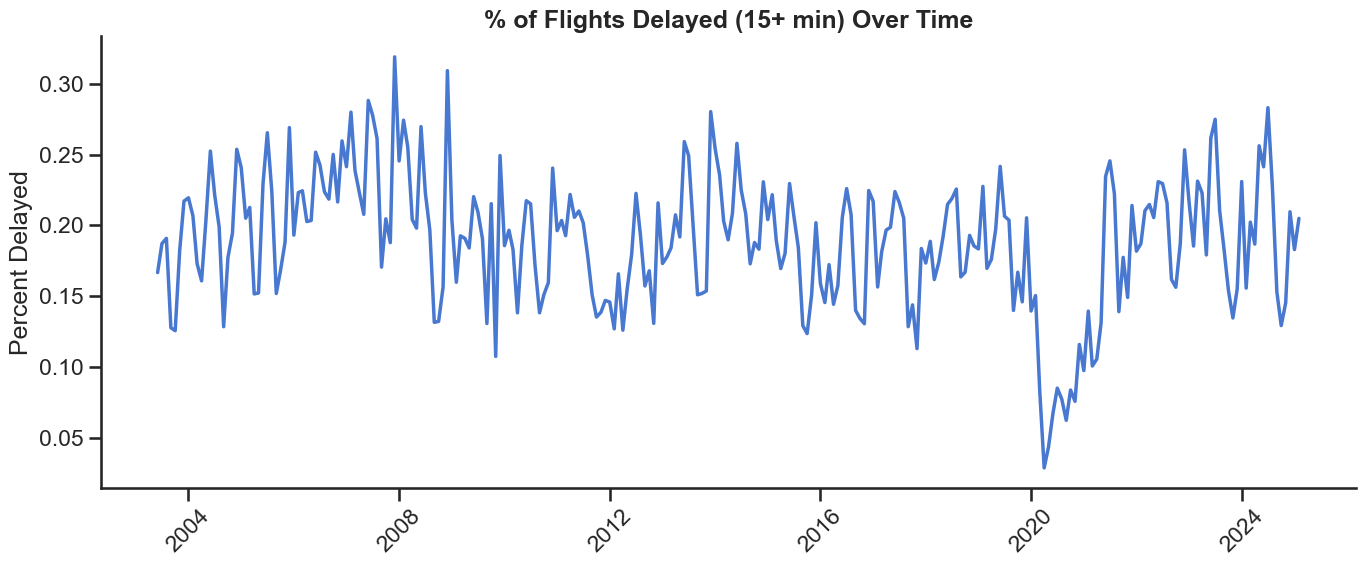

In [40]:
plot_line(
    data=monthly_stats,
    x='date',
    y='pct_delayed',
    title='% of Flights Delayed (15+ min) Over Time',
    ylabel='Percent Delayed'
)

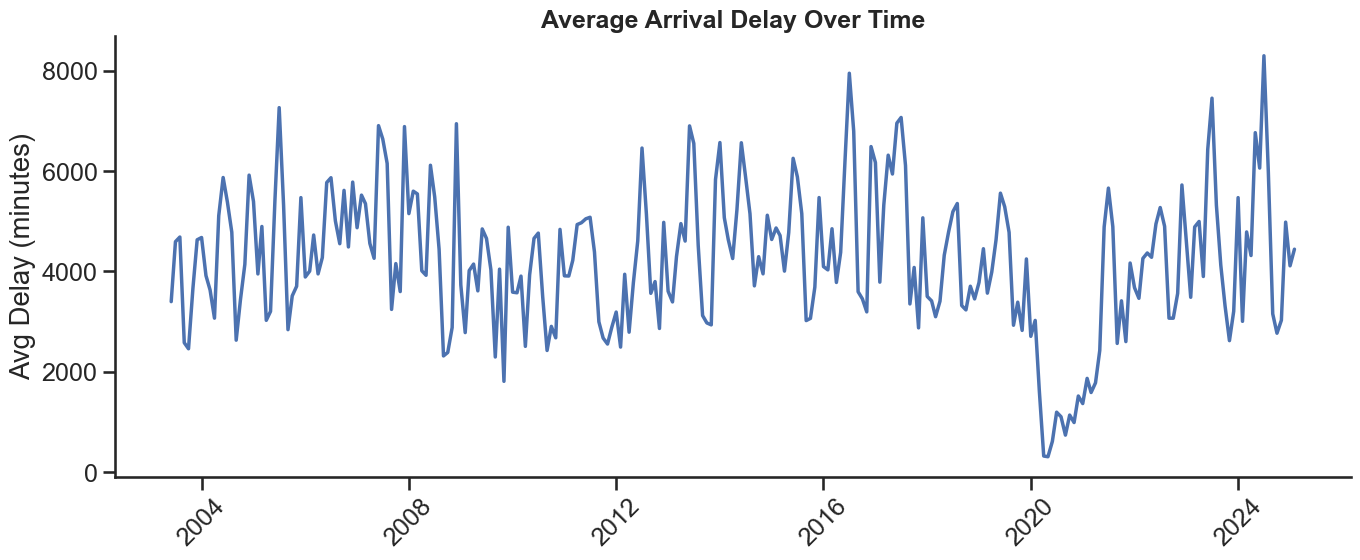

In [37]:
plot_line(
    data=monthly_stats,
    x='date',
    y='avg_arr_delay',
    title='Average Arrival Delay Over Time',
    ylabel='Avg Delay (minutes)'
)


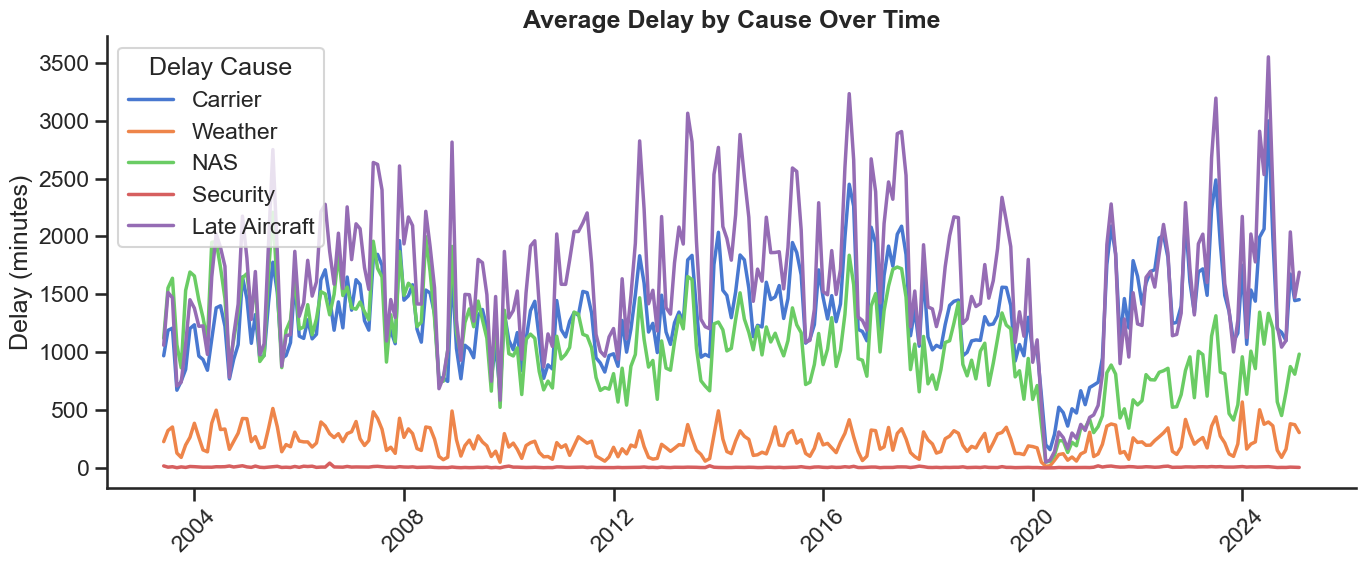

In [41]:
plt.figure(figsize=(14, 6))
delay_cols = {
    'avg_carrier_delay': 'Carrier',
    'avg_weather_delay': 'Weather',
    'avg_nas_delay': 'NAS',
    'avg_security_delay': 'Security',
    'avg_late_aircraft_delay': 'Late Aircraft'
}

for col, label in delay_cols.items():
    sns.lineplot(data=monthly_stats, x='date', y=col, label=label, linewidth=2.5)

plt.title('Average Delay by Cause Over Time', fontsize=18, fontweight='bold')
plt.ylabel('Delay (minutes)')
plt.xlabel('')
plt.legend(title='Delay Cause')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.show()


In [42]:
# Step 1: Create a monthly grouped dataset
monthly_group = (
    df.groupby(['year', 'month', 'airport', 'carrier'])
    .agg(
        avg_flights=('arr_flights', 'mean'),
        avg_delays=('arr_del15', 'mean'),
        count_months=('arr_flights', 'count')
    )
    .reset_index()
)

# Step 2: Create a unique key for pair and calculate summary stats
monthly_group['pair'] = monthly_group['airport'] + ' - ' + monthly_group['carrier']

# Step 3: Rank pairs by:
# - number of months of data
# - average monthly volume
pair_summary = (
    monthly_group.groupby('pair')
    .agg(
        total_months=('count_months', 'sum'),
        avg_monthly_flights=('avg_flights', 'mean'),
        avg_monthly_delays=('avg_delays', 'mean')
    )
    .reset_index()
)

# Step 4: Filter and sort to find good candidates
good_pairs = pair_summary.query("total_months >= 36")  # e.g., at least 3 years of data

top_pairs = good_pairs.sort_values(
    by=['avg_monthly_flights', 'avg_monthly_delays'],
    ascending=False
)

# Display top 10 candidates
top_pairs.head(10)


,pair,total_months,avg_monthly_flights,avg_monthly_delays
179,ATL - DL,261,16874.681992,2573.915709
1138,DFW - AA,261,12623.988506,2271.264368
2814,MSP - NW,79,7839.443038,1439.898734
1237,DTW - NW,79,7680.924051,1378.000000
1939,IAH - RU,37,7408.864865,1335.432432
1943,IAH - XE,66,7257.984848,1305.833333
180,ATL - EV,201,7145.427861,1678.980100
865,CLT - US,145,6878.475862,1127.041379
1927,IAH - CO,103,6823.000000,1116.135922
3046,ORD - UA,261,6319.363985,1207.459770


,year,month
0,2003,6
1,2003,7
2,2003,8
3,2003,9
4,2003,10
...,...,...
256,2024,10
257,2024,11
258,2024,12
259,2025,1
